#**MAESTRÍA EN ANÁLISIS DE DATOS Y SISTEMAS INTELIGENTES**

## **ESTUDIO COMPARATIVO DE MODELOS DE APRENDIZAJE SUPERVISADO**


*   Edwar David Macías López
*   Miguel Andres Arias Romero
*   Javier Santiago Hernandez Mendez
*   Jhon Freddy Hernandez Corzo

#**Alistamiento y limpieza de datos**

En primer lugar se realiza el import de la libreria **Pandas**, se leen los datos del data-set y posteriormente se almacenan en el dataframe **df**.

Se hace una vista rápida de los datos para revisar nombres de columnas, tipos de valores y si hay errores evidentes, en los 5 primeros registros:

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/MADSI/SiniestrosBog_DataSet.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ahora se valida la información general del DataFrame, se verifican los nombres de columnas, cantidad de valores no nulos, tipo de dato de cada columna (object, int64, float64, etc.) y número total de filas:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196152 entries, 0 to 196151
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   FECHA        196152 non-null  object 
 1   HORA         196152 non-null  object 
 2   LOCALIDAD    196152 non-null  object 
 3   GRAVEDAD     196152 non-null  object 
 4   CLASE        196152 non-null  object 
 5   CHOQUE       167910 non-null  float64
 6   OBJETO_FIJO  6689 non-null    float64
 7   DIRECCION    196152 non-null  object 
 8   ACTOR VIAL   196004 non-null  object 
dtypes: float64(2), object(7)
memory usage: 13.5+ MB


También se realiza la validación de las muestra estadísticas descriptivas de las columnas numéricas por defecto.

Se verifica la Media, Desviación estándar, Mínimo, Máximo y Cuartiles (25%, 50%, 75%):

In [ ]:
df.describe()

,CHOQUE,OBJETO_FIJO
count,167910.000000,6689.000000
mean,1.127717,5.318583
std,0.610152,3.756058
min,1.000000,1.000000
25%,1.000000,2.000000
50%,1.000000,5.000000
75%,1.000000,10.000000
max,5.000000,16.000000


Se verifican cuántos valores nulos (NaN) hay por columna:

In [ ]:
df.isnull().sum()

,0
FECHA,0
HORA,0
LOCALIDAD,0
GRAVEDAD,0
CLASE,0
CHOQUE,28242
OBJETO_FIJO,189463
DIRECCION,0
ACTOR VIAL,148


Y también cuántas filas duplicadas hay en el DataFrame:

In [ ]:
df.duplicated().sum()

np.int64(65)

Se eliminan las columnas poco representativas para el ejericio y los valores duplicados.

Se visualiza de nuevo el DataFrame:

In [ ]:
df.drop(columns=['DIRECCION', 'CHOQUE', 'OBJETO_FIJO'], inplace=True)
df.drop_duplicates(inplace=True)
df = df.dropna()
df.head()

,FECHA,HORA,LOCALIDAD,GRAVEDAD,CLASE,ACTOR VIAL
0,1/1/2015,01:05:00,Puente Aranda,Con Heridos,Atropello,CONDUCTOR
1,1/1/2015,05:50:00,Bosa,Con Heridos,Volcamiento,MOTOCICLISTA
2,1/1/2015,07:15:00,Ciudad Bolívar,Con Heridos,Volcamiento,MOTOCICLISTA
3,1/1/2015,09:30:00,Kennedy,Solo Daños,Choque,CONDUCTOR
4,1/1/2015,09:45:00,Engativá,Con Heridos,Choque,CONDUCTOR


Ahora se realiza la codificación de la variable objetivo GRAVEDAD, para lo cual se crea la columna codificada GRAVEDAD_COD:

In [ ]:
gravedad_map = {
    'Solo Daños': 0,
    'Con Heridos': 1,
    'Con Muertos': 2
}
df['GRAVEDAD_COD'] = df['GRAVEDAD'].map(gravedad_map)

<ipython-input-27-6edf92013584>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GRAVEDAD_COD'] = df['GRAVEDAD'].map(gravedad_map)


Otra transformación que se puede aplicar es extraer la hora numérica de la columna HORA, con el fin de mediante una función, categorizar las horas de los accidentes en franjas y crear la columna HORA_FRANJA:

In [ ]:
df['HORA_NUM'] = df['HORA'].str.extract(r'(\d{1,2})').astype(float)

def categorizar_franja(hora):
    if 5 <= hora < 10:
        return 'Madrugada'
    elif 10 <= hora < 14:
        return 'Mañana'
    elif 14 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 22:
        return 'Noche'
    else:
        return 'Madrugada Tarde'

df['HORA_FRANJA'] = df['HORA_NUM'].apply(categorizar_franja)


Se realiza la transformación de variables de tiempo y se procede a crear columna DIA_SEMANA:

In [ ]:
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['DIA_SEMANA'] = df['FECHA'].dt.day_name()

df.head()

,FECHA,HORA,LOCALIDAD,GRAVEDAD,CLASE,ACTOR VIAL,GRAVEDAD_COD,HORA_NUM,HORA_FRANJA,DIA_SEMANA
0,2015-01-01,01:05:00,Puente Aranda,Con Heridos,Atropello,CONDUCTOR,1,1.0,Madrugada Tarde,Thursday
1,2015-01-01,05:50:00,Bosa,Con Heridos,Volcamiento,MOTOCICLISTA,1,5.0,Madrugada,Thursday
2,2015-01-01,07:15:00,Ciudad Bolívar,Con Heridos,Volcamiento,MOTOCICLISTA,1,7.0,Madrugada,Thursday
3,2015-01-01,09:30:00,Kennedy,Solo Daños,Choque,CONDUCTOR,0,9.0,Madrugada,Thursday
4,2015-01-01,09:45:00,Engativá,Con Heridos,Choque,CONDUCTOR,1,9.0,Madrugada,Thursday


Posteriormente se identifican y codifican las variables categóricas.  Se podría usar **One Hot Encoding** pero en este caso se realiza la codificación con **Ordinal Encoding** para tener un enfoque más simple manteniendo las columnas con valores numéricos y sin aumentar dimensionalidad:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df[['LOCALIDAD', 'CLASE', 'ACTOR VIAL', 'HORA_FRANJA', 'DIA_SEMANA']] = encoder.fit_transform(df[['LOCALIDAD', 'CLASE', 'ACTOR VIAL', 'HORA_FRANJA', 'DIA_SEMANA']])

df.head()

,FECHA,HORA,LOCALIDAD,GRAVEDAD,CLASE,ACTOR VIAL,GRAVEDAD_COD,HORA_NUM,HORA_FRANJA,DIA_SEMANA
0,2015-01-01,01:05:00,10.0,Con Heridos,0.0,1.0,1,1.0,1.0,4.0
1,2015-01-01,05:50:00,2.0,Con Heridos,6.0,2.0,1,5.0,0.0,4.0
2,2015-01-01,07:15:00,4.0,Con Heridos,6.0,2.0,1,7.0,0.0,4.0
3,2015-01-01,09:30:00,7.0,Solo Daños,3.0,1.0,0,9.0,0.0,4.0
4,2015-01-01,09:45:00,5.0,Con Heridos,3.0,1.0,1,9.0,0.0,4.0


Se validan los resultado:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194035 entries, 0 to 196151
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   FECHA         194035 non-null  datetime64[ns]
 1   HORA          194035 non-null  object        
 2   LOCALIDAD     194035 non-null  float64       
 3   GRAVEDAD      194035 non-null  object        
 4   CLASE         194035 non-null  float64       
 5   ACTOR VIAL    194035 non-null  float64       
 6   GRAVEDAD_COD  194035 non-null  int64         
 7   HORA_NUM      194035 non-null  float64       
 8   HORA_FRANJA   194035 non-null  float64       
 9   DIA_SEMANA    194035 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 16.3+ MB


# **Modelo de Clasificación**

 Teniendo los datos limpios y estructurados, se aplicaran las tecnicas de clasificación, usando como **variable objetivo** la Gravedad (GRAVEDAD_COD: 0 = Solo Daños, 1 = Con Heridos, 2 = Con Muertos):

 1. Se procede a separar la varible objetivo:

In [ ]:
y = df['GRAVEDAD_COD']
y.head()

,GRAVEDAD_COD
0,1
1,1
2,1
3,0
4,1


In [ ]:
y.describe()

,GRAVEDAD_COD
count,194035.000000
mean,0.366408
std,0.512860
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [ ]:
df.describe()

,FECHA,LOCALIDAD,CLASE,ACTOR VIAL,GRAVEDAD_COD,HORA_NUM,HORA_FRANJA,DIA_SEMANA
count,194035,194035.000000,194035.000000,194035.000000,194035.000000,194035.000000,194035.000000,194035.000000
mean,2017-11-27 22:23:22.893292288,9.085593,2.713768,1.126843,0.366408,12.898359,2.077630,3.000072
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016-07-16 00:00:00,5.000000,3.000000,1.000000,0.000000,9.000000,1.000000,1.000000
50%,2017-11-30 00:00:00,7.000000,3.000000,1.000000,0.000000,13.000000,2.000000,3.000000
75%,2019-04-06 00:00:00,14.000000,3.000000,1.000000,1.000000,17.000000,3.000000,5.000000
max,2020-12-31 00:00:00,19.000000,6.000000,4.000000,2.000000,23.000000,4.000000,6.000000
std,NaN,5.571194,1.005720,0.371577,0.512860,5.405103,1.483703,2.063042


2. De las demás variables (variables predictoras) se excluyen las varibles que no serán de mucha utilidad:

In [ ]:
X = df.drop(columns=['GRAVEDAD', 'GRAVEDAD_COD', 'FECHA', 'HORA'])
X.head()


,LOCALIDAD,CLASE,ACTOR VIAL,HORA_NUM,HORA_FRANJA,DIA_SEMANA
0,10.0,0.0,1.0,1.0,1.0,4.0
1,2.0,6.0,2.0,5.0,0.0,4.0
2,4.0,6.0,2.0,7.0,0.0,4.0
3,7.0,3.0,1.0,9.0,0.0,4.0
4,5.0,3.0,1.0,9.0,0.0,4.0


3. Se dividen los datos en los conjuntos de entrenamiento (train) y prueba (test), así:

*   Se define para la varible **test_size=0.2** lo que permitirá que el 20% de los datos se utilicen para prueba, y el 80% para entrenamiento.
*   Se define el valor de **random_state=42** para garantiza que la división sea reproducible cada vez que ejecutes el código.
*   Adicionalmente se define el valor de **stratify=y** en y, para que se mantengan la proporción de clases de la variable objetivo (y) tanto en el conjunto de entrenamiento como en el de prueba.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
y_train

,GRAVEDAD_COD
167284,0
99257,0
124944,0
171654,0
180884,0
...,...
129763,1
92676,1
111929,1
65029,0


SMOTE (Synthetic Minority Oversampling Technique) genera datos sintéticos para clases con pocos registros.

Se aplica solo en X_train/y_train, nunca en X_test.

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Distribución después de SMOTE:")
print(Counter(y_train_res))


Distribución después de SMOTE:
Counter({0: 100747, 1: 100747, 2: 100747})


**Random Forest:**

Se define la importación del modelo **RandomForestClassifier** de la llibreria **sklearn.ensemble** y posteriormente se crea el objeto con los siguientes parámetros personalizados:

  *   **random_state=42**: Semilla aleatoria fija para que el resultado sea reproducible.
  *   **bootstrap=True y oob_score=True** permiten usar OOB score como validación interna.

Posteriormente se entrena el modelo:

In [ ]:
modelo = RandomForestClassifier(random_state=42, bootstrap=True, oob_score=True)


Define combinaciones de hiperparámetros que GridSearchCV va a probar.

class_weight='balanced' es clave para datos desbalanceados.

In [ ]:
# Hiperparámetros a buscar
param_grid = {
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

GridSearchCV entrena 5 modelos diferentes (CV=5) por cada combinación.

Usa f1_macro como métrica, que trata todas las clases por igual.

Escoge la mejor combinación según el promedio de esa métrica.

In [ ]:
# Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [None, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5]},
             scoring='f1_macro', verbose=1)

Extrae el mejor modelo entrenado según los resultados del GridSearch.

In [ ]:
mejor_modelo = grid_search.best_estimator_
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)


Mejores parámetros encontrados:
{'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5}


y_pred: etiquetas predichas.

y_prob: probabilidades predichas, necesarias para calcular AUC.

In [ ]:
y_pred = mejor_modelo.predict(X_test)
y_prob = mejor_modelo.predict_proba(X_test)


Accuracy general.

classification_report: muestra precision, recall, y F1-score para cada clase.

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.2f}")
print("\nReporte de Clasificación (F1, Precision, Recall):")
print(classification_report(y_test, y_pred, target_names=['Solo Daños', 'Con Heridos', 'Con Muertos'], zero_division=0))


Accuracy: 0.78

Reporte de Clasificación (F1, Precision, Recall):
              precision    recall  f1-score   support

  Solo Daños       0.81      0.91      0.86     25187
 Con Heridos       0.74      0.57      0.65     13021
 Con Muertos       0.09      0.06      0.07       599

    accuracy                           0.78     38807
   macro avg       0.54      0.51      0.52     38807
weighted avg       0.77      0.78      0.77     38807



Mide qué tan bien el modelo distingue entre clases.

ovr: compara cada clase vs el resto.

macro: hace un promedio de todas las clases.

In [ ]:
try:
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
    print(f"AUC (ROC macro): {auc:.2f}")
except Exception as e:
    print("No se pudo calcular AUC:", e)


AUC (ROC macro): 0.74


Estimación interna de error que hace Random Forest sin usar validación cruzada adicional.

Solo disponible si bootstrap=True y oob_score=True.

In [ ]:
if hasattr(mejor_modelo, 'oob_score_'):
    print(f"OOB Score del mejor modelo: {mejor_modelo.oob_score_:.2f}")


OOB Score del mejor modelo: 0.82


Muestra cuántas veces el modelo acertó o se equivocó por clase.

Es ideal para ver si mejora la predicción de la clase minoritaria ("Con Muertos").

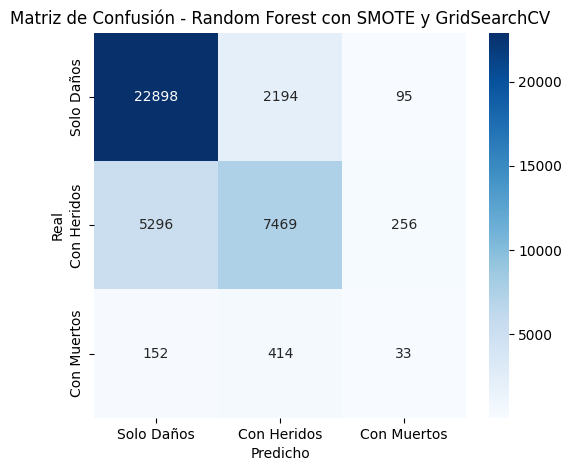

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Solo Daños', 'Con Heridos', 'Con Muertos'],
            yticklabels=['Solo Daños', 'Con Heridos', 'Con Muertos'])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest con SMOTE y GridSearchCV")
plt.show()


FIN